In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2023-02-12 02:02:04--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 142.250.4.139, 142.250.4.102, 142.250.4.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ube5749rl2qg26rqamddkmi8s1a0fkol/1676167275000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=efa1f3d5-fd1a-4853-b65b-363666f3202e [following]
--2023-02-12 02:02:06--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ube5749rl2qg26rqamddkmi8s1a0fkol/1676167275000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=efa1f3d5-fd1a-4853-b65b-363666f3202e
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.24.132, 2404:6800:4003:c03::84
Connecting to doc-08-ak-d

In [4]:
dataset = pd.read_csv('/tmp/sentiment.csv')

# Extract out sentences and labels
sentences = np.array(dataset['text'])
labels = np.array(dataset['sentiment'])

In [7]:
for x in range(2):
  print(sentences[x], ' ', labels[x])

So there is no way for me to plug it in here in the US unless I go by a converter.   0
Good case Excellent value.   1


In [9]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, 
                                                                      max_subword_length=5)
print(tokenizer.vocab_size)

999


In [11]:
print(sentences[2])

Great for the jawbone.


In [13]:
encoded = tokenizer.encode(sentences[2])
encoded

[134, 775, 17, 1, 849, 179, 205, 52, 789]

In [15]:
for index in encoded:
  print(tokenizer.decode([index]))

Great
 
for 
the 
j
aw
bo
ne
.


In [16]:
encoded_sentences = []
for i, sentence in enumerate(sentences):
  encoded_sentences.append(tokenizer.encode(sentence))

In [17]:
encoded_sentences[3]

[827,
 187,
 11,
 6,
 143,
 63,
 17,
 79,
 227,
 594,
 331,
 3,
 660,
 26,
 313,
 182,
 795,
 415,
 374,
 60,
 789,
 820,
 808,
 817,
 822,
 825,
 775,
 823,
 825,
 822,
 809,
 819,
 812,
 820,
 826,
 263]

In [31]:
encoded_sentences[0]

TypeError: ignored

In [32]:
max_length = 50
padded_sequences = tf.keras.utils.pad_sequences(encoded_sentences, maxlen=max_length, 
                                                padding='post', truncating='post')

In [36]:
training_size = int(len(sentences) * 0.8)

training_sequences = padded_sequences[0:training_size]
testing_sequences = padded_sequences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [42]:
embedding_dim = 16
num_epochs = 30

def compile_model(model):
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels))
  return history

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def predict_new_sentences(model, new_sentences, maxlen=max_length):
  encoded_sentences = []
  for i, sentence in enumerate(new_sentences):
    encoded_sentences.append(tokenizer.encode(sentence))
  
  padded_sequences = tf.keras.utils.pad_sequences(encoded_sentences, maxlen=maxlen, 
                                                  padding='post', truncating='post')
  predictions = model.predict(padded_sequences)

  for i, res in enumerate(predictions):
    print(new_sentences[i], ' ', res)

def fit_model_and_show_results (model, new_sentences):
  history = compile_model(model)
  plot_results(history)
  predict_new_sentences(model, new_sentences)

In [39]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 102       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 12s 147ms/step - loss: 0.6927 - accuracy: 0.5116 - val_loss: 0.6

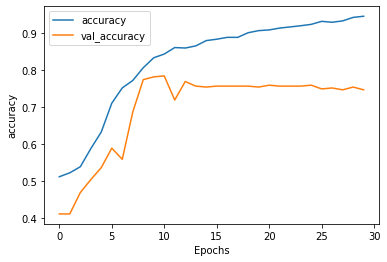

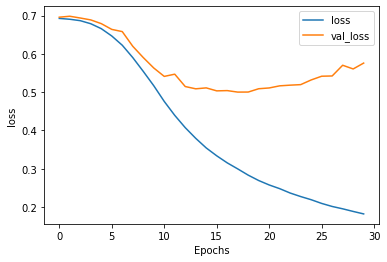

1/1 [==============================] - 0s 86ms/step
I love this phone   [0.8680906]
Everything was cold   [0.1037043]
Everything was hot exactly as I wanted   [0.3081045]
Everything was green   [0.0890369]
the host seated us immediately   [0.3887572]
they gave us free chocolate cake   [0.68913686]
we couldn't hear each other talk because of the shouting in the kitchen   [0.0107198]


In [43]:
embedding_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


fit_model_and_show_results(embedding_model, fake_reviews)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 12s 112ms/step - loss: 0.6903 - accuracy: 0.5286 - val_loss: 0.6

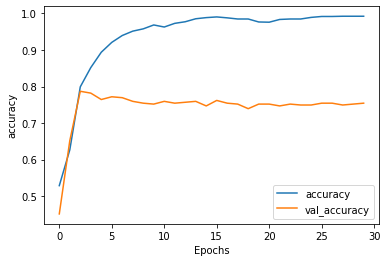

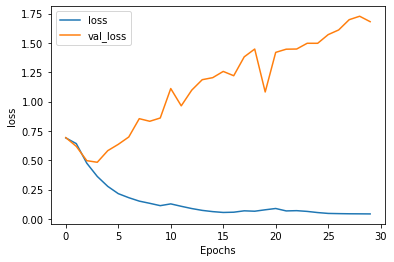

1/1 [==============================] - 1s 744ms/step
I love this phone   [0.9998814]
Everything was cold   [0.01876257]
Everything was hot exactly as I wanted   [0.18192984]
Everything was green   [0.02404845]
the host seated us immediately   [0.9998416]
they gave us free chocolate cake   [0.7334019]
we couldn't hear each other talk because of the shouting in the kitchen   [0.01147015]


In [44]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


fit_model_and_show_results(lstm_model, fake_reviews)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 6)                 198       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-trai

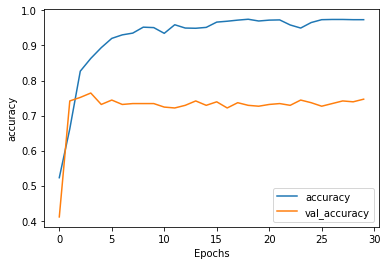

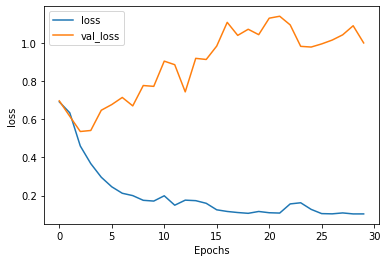

1/1 [==============================] - 1s 1s/step
I love this phone   [0.99521625]
Everything was cold   [0.04603747]
Everything was hot exactly as I wanted   [0.03536613]
Everything was green   [0.03693009]
the host seated us immediately   [0.03770425]
they gave us free chocolate cake   [0.9956546]
we couldn't hear each other talk because of the shouting in the kitchen   [0.03319842]


In [45]:
sequences_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


fit_model_and_show_results(sequences_lstm_model, fake_reviews)

In [48]:
test_sentences = ["nice environment", "waste time", 
                  "The movie is as exciting as the one we saw yesterday", 
                  "The movement is so loud that the thief wakes up the girl", 
                  "I would not say the expensive price is not worth for the laptop", 
                  "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
                  "I would never go that place again"]

In [49]:
predict_new_sentences(embedding_model, test_sentences)
predict_new_sentences(lstm_model, test_sentences)
predict_new_sentences(sequences_lstm_model, test_sentences)

1/1 [==============================] - 0s 21ms/step
nice environment   [0.88190436]
waste time   [0.1697473]
The movie is as exciting as the one we saw yesterday   [0.78438175]
The movement is so loud that the thief wakes up the girl   [0.4414955]
I would not say the expensive price is not worth for the laptop   [0.11886784]
for a phone that is as expensive as this one I expect it to be much easier to use than this thing is   [0.5653683]
I would never go that place again   [0.15188178]
1/1 [==============================] - 0s 23ms/step
nice environment   [0.96410775]
waste time   [0.01503132]
The movie is as exciting as the one we saw yesterday   [0.99999785]
The movement is so loud that the thief wakes up the girl   [0.999554]
I would not say the expensive price is not worth for the laptop   [0.01101692]
for a phone that is as expensive as this one I expect it to be much easier to use than this thing is   [0.01765161]
I would never go that place again   [0.01532855]
1/1 [============